In [12]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [13]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [14]:
# Step 1: Load Data 
otu_df = pd.read_csv('OTU.csv')  
taxonomy_df = pd.read_csv('taxonomy.csv')  
pathway_df = pd.read_csv('pathway_prediction.csv')  
functional_df = pd.read_csv('functional_prediction.csv')  

# Step 2: Preprocess the Data
# Normalize the OTU counts
otu_counts = otu_df[['AB', 'COM', 'CON', 'PHY']]
otu_counts_normalized = otu_counts.div(otu_counts.sum(axis=1), axis=0)

# Merge taxonomy data with OTU counts (excluding taxonomy for now)
otu_with_taxonomy = pd.concat([otu_counts_normalized], axis=1)

# Merge with pathway and functional predictions (based on common KOs, pathways, etc.)
# For demonstration purposes, we'll assume simple concatenation. In practice, you'll likely need to join on some IDs.
merged_data = pd.concat([otu_with_taxonomy, pathway_df[['AB', 'COM', 'CON', 'PHY']], functional_df[['AB', 'COM', 'CON', 'PHY']]], axis=1)
# Load your phenotypic data
phenotype_df = pd.read_csv('phenotype_data.csv')  # Replace with actual phenotype file path
data_with_target = merged_data.merge(phenotype_df, left_index=True, right_index=True)

# Exclude non-numeric columns from X
X = data_with_target.select_dtypes(include=[float, int])  # Only numeric features
y = data_with_target['Value']  #  # Target variable

# Step 4: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Training Ridge Regression...
Ridge Regression - MSE: 108.67854697822483, R^2: 0.8767489912853966
Training Lasso Regression...
Lasso Regression - MSE: 0.28993893463846104, R^2: 0.9996711838062484
Training Support Vector Regressor...
Support Vector Regressor - MSE: 1084.695003723712, R^2: -0.23013931519920394
Training Pruned Decision Tree...
Pruned Decision Tree - MSE: 564.5536829999999, R^2: 0.3597465844180262
Training Random Forest...
Random Forest - MSE: 438.51344569918393, R^2: 0.5026872734306067
Training Gradient Boosting...
Gradient Boosting - MSE: 190.33552020208393, R^2: 0.7841428183261785

Model Evaluation Results:
                           Mean Squared Error  R^2 Score
Ridge Regression                  108.678547   0.876749
Lasso Regression                    0.289939   0.999671
Support Vector Regressor         1084.695004  -0.230139
Pruned Decision Tree              564.553683   0.359747
Random Forest                     438.513446   0.502687
Gradient Boosting                

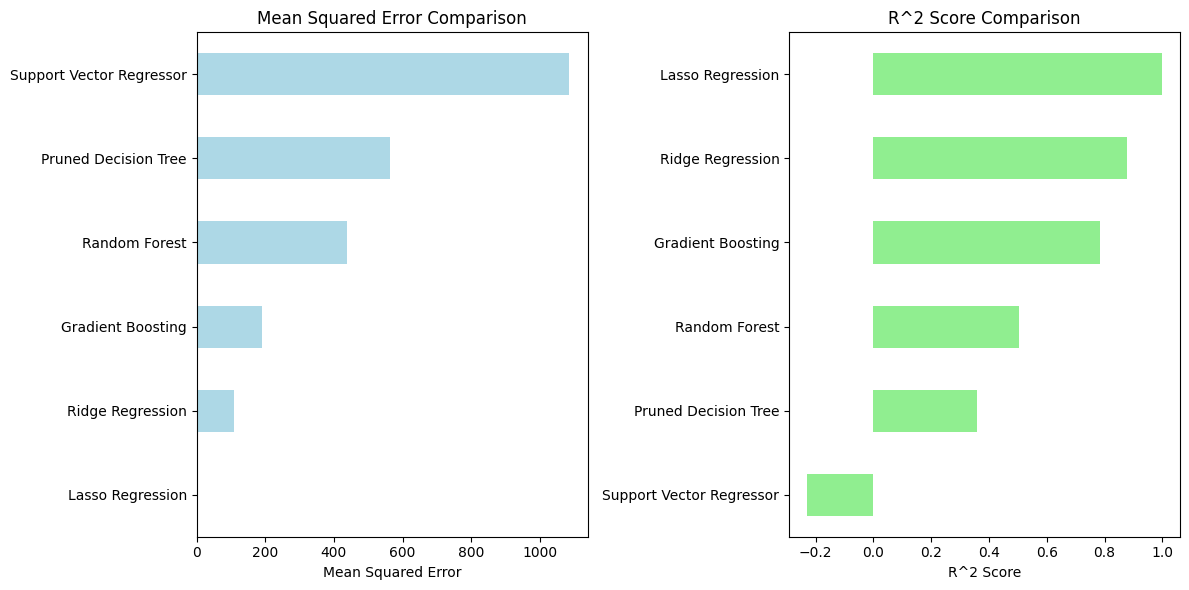

In [15]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Gradient Boosting with early stopping
gradient_boosting = GradientBoostingRegressor(random_state=42, n_estimators=100)

# Set up the parameter grid for Gradient Boosting
gb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'subsample': [0.8, 0.9],  # Subsample for randomness
    'n_estimators': [100, 200]
}

# Random Forest with more tuning
random_forest = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10]
}

# Ridge and Lasso with more regularization
ridge = Ridge(alpha=20.0)  # Increased alpha for stronger regularization
lasso = Lasso(alpha=0.5)   # Increased alpha for stronger regularization

# Support Vector Regressor with further tuning
svr = SVR(C=1, gamma=0.1, kernel='rbf')  # Increased C and adjusted gamma for better fit

# Pruned Decision Tree
decision_tree = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=20, min_samples_leaf=10)

# Set up the models dictionary
models = {
    'Ridge Regression': ridge,
    'Lasso Regression': lasso,
    'Support Vector Regressor': svr,
    'Pruned Decision Tree': decision_tree,
    'Random Forest': GridSearchCV(random_forest, param_grid=rf_param_grid, cv=5, n_jobs=-1),
    'Gradient Boosting': GridSearchCV(gradient_boosting, param_grid=gb_param_grid, cv=5, n_jobs=-1)
}

# Train and evaluate each model
predictions = {}
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Store predictions for visualization
    predictions[model_name] = y_pred
    
    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'Mean Squared Error': mse,
        'R^2 Score': r2
    }
    
    print(f"{model_name} - MSE: {mse}, R^2: {r2}")

# Convert the results to a DataFrame for easy display
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:\n", results_df)

### Visualization (same as before)
plt.figure(figsize=(12, 6))

# Bar chart for MSE
plt.subplot(1, 2, 1)
results_df['Mean Squared Error'].sort_values().plot(kind='barh', color='lightblue')
plt.title('Mean Squared Error Comparison')
plt.xlabel('Mean Squared Error')

# Bar chart for R^2 score
plt.subplot(1, 2, 2)
results_df['R^2 Score'].sort_values().plot(kind='barh', color='lightgreen')
plt.title('R^2 Score Comparison')
plt.xlabel('R^2 Score')

plt.tight_layout()
plt.show()


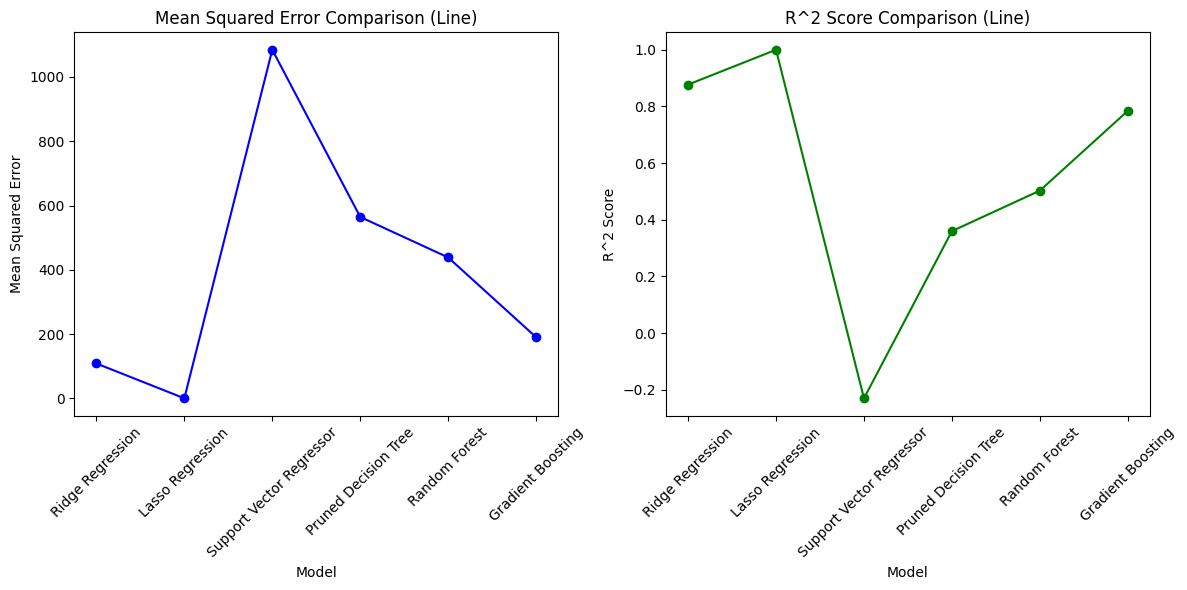

In [16]:
### Line Graph Comparison ###
plt.figure(figsize=(12, 6))

# Line graph for MSE comparison
plt.subplot(1, 2, 1)
plt.plot(results_df.index, results_df['Mean Squared Error'], marker='o', linestyle='-', color='blue')
plt.title('Mean Squared Error Comparison (Line)')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)

# Line graph for R^2 score comparison
plt.subplot(1, 2, 2)
plt.plot(results_df.index, results_df['R^2 Score'], marker='o', linestyle='-', color='green')
plt.title('R^2 Score Comparison (Line)')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Parameter grid for Lasso Regression fine-tuning
lasso_param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10, 20],  # Regularization strength
    'max_iter': [1000, 5000, 10000]     # Maximum number of iterations for convergence
}

# Fine-tuning for Lasso Regression
print("Fine-tuning Lasso Regression...")
lasso = Lasso(random_state=42)

# GridSearchCV for Lasso Regressor
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=lasso_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_scaled, y_train)

# Get the best parameters and score
print(f"Best parameters for Lasso Regression: {grid_search_lasso.best_params_}")
best_lasso = grid_search_lasso.best_estimator_

# Make predictions with the best model
y_pred_lasso_tuned = best_lasso.predict(X_test_scaled)

# Evaluate the tuned model
mse_lasso_tuned = mean_squared_error(y_test, y_pred_lasso_tuned)
r2_lasso_tuned = r2_score(y_test, y_pred_lasso_tuned)
print(f"Tuned Lasso Regression - MSE: {mse_lasso_tuned}, R^2: {r2_lasso_tuned}")



Fine-tuning Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 0.1, 'max_iter': 1000}
Tuned Lasso Regression - MSE: 0.01159755738553849, R^2: 0.99998684735225
